# 使用时间序列Transformers

In [1]:
%pip install 'chronos-forecasting>=2.1' 'pandas[pyarrow]' 'matplotlib'

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os

# Use only 1 GPU if available
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chronos import BaseChronosPipeline, Chronos2Pipeline

# Load the Chronos-2 pipeline
# GPU recommended for faster inference, but CPU is also supported
pipeline: Chronos2Pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cpu")

In [12]:
context_df = pd.read_excel("data/2023_MCM_Problem_C_Data.xlsx")
print("Input dataframe shape:", context_df.shape)
display(context_df.head())

Input dataframe shape: (359, 12)


,timestamp,item_id,Word,target,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
0,2022-12-31,560,manly,20380,1899,0,2,17,37,29,12,2
1,2022-12-30,559,molar,21204,1973,0,4,21,38,26,9,1
2,2022-12-29,558,havoc,20001,1919,0,2,16,38,30,12,2
3,2022-12-28,557,impel,20160,1937,0,3,21,40,25,9,1
4,2022-12-27,556,condo,20879,2012,0,2,17,35,29,14,3


In [15]:
# 数据需要重新组织：将整个数据视为单一时间序列
# 首先按时间排序，然后创建单一序列格式

# 按时间排序（从早到晚）
context_df_sorted = context_df.sort_values('timestamp').reset_index(drop=True)

# 创建适合 Chronos-2 的数据格式：单一时间序列
# 使用固定的 item_id 表示这是同一个序列
ts_df = pd.DataFrame({
    'timestamp': context_df_sorted['timestamp'],
    'item_id': 1,  # 所有数据点属于同一个序列
    'target': context_df_sorted['target']  # 预测目标列
})

print("重新组织后的数据:")
print(f"时间范围: {ts_df['timestamp'].min()} 到 {ts_df['timestamp'].max()}")
print(f"数据点数: {len(ts_df)}")
display(ts_df.head())

重新组织后的数据:
时间范围: 2022-01-07 00:00:00 到 2022-12-31 00:00:00
数据点数: 359


,timestamp,item_id,target
0,2022-01-07,1,80630
1,2022-01-08,1,101503
2,2022-01-09,1,91477
3,2022-01-10,1,107134
4,2022-01-11,1,153880


In [17]:
# 使用 Chronos-2 进行预测
pred_df = pipeline.predict_df(
    ts_df, 
    prediction_length=60, 
    quantile_levels=[0.1, 0.5, 0.9],
    id_column='item_id',
    timestamp_column='timestamp',
    target='target'
)

print("预测结果:")
print("Output dataframe shape:", pred_df.shape)
display(pred_df.head(10))

预测结果:
Output dataframe shape: (60, 7)


/opt/anaconda3/envs/machine_learning/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


,item_id,timestamp,target_name,predictions,0.1,0.5,0.9
0,1,2023-01-01,target,20977.742188,18803.414062,20977.742188,22752.109375
1,1,2023-01-02,target,20989.289062,18709.414062,20989.289062,22892.359375
2,1,2023-01-03,target,20894.992188,18514.679688,20894.992188,22554.398438
3,1,2023-01-04,target,20678.460938,18474.484375,20678.460938,22332.117188
4,1,2023-01-05,target,20141.140625,18272.898438,20141.140625,22372.570312
5,1,2023-01-06,target,20406.562500,18035.812500,20406.562500,22175.500000
6,1,2023-01-07,target,20194.132812,18004.148438,20194.132812,21773.132812
7,1,2023-01-08,target,19908.804688,17771.562500,19908.804688,21794.445312
8,1,2023-01-09,target,19662.601562,17556.789062,19662.601562,21804.671875
9,1,2023-01-10,target,20072.539062,17591.062500,20072.539062,22061.742188


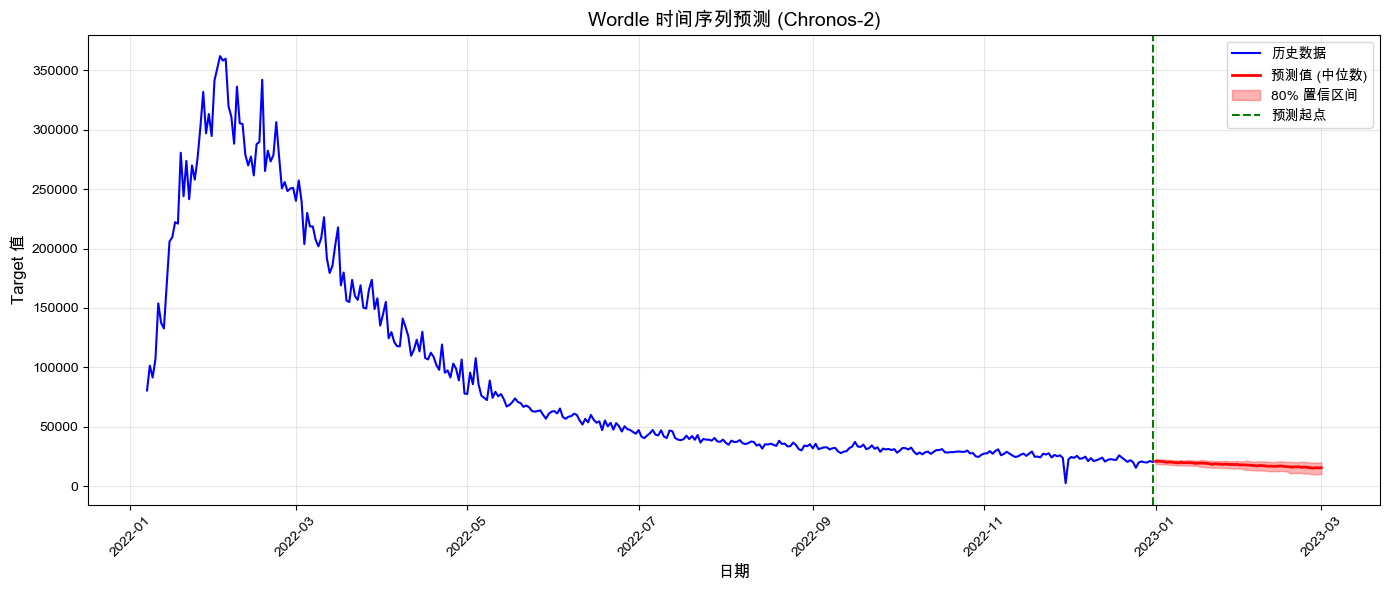

In [21]:
# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'STHeiti']  # macOS 中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 可视化：历史数据 + 预测结果
fig, ax = plt.subplots(figsize=(14, 6))

# 绘制历史数据
ax.plot(ts_df['timestamp'], ts_df['target'], 
        label='历史数据', color='blue', linewidth=1.5)

# 绘制预测结果（中位数和置信区间）
ax.plot(pred_df['timestamp'], pred_df['0.5'], 
        label='预测值 (中位数)', color='red', linewidth=2)

# 绘制置信区间 (10%-90%)
ax.fill_between(pred_df['timestamp'], 
                pred_df['0.1'], 
                pred_df['0.9'],
                alpha=0.3, color='red', label='80% 置信区间')

# 添加分割线标记预测开始点
last_historical_date = ts_df['timestamp'].iloc[-1]
ax.axvline(x=last_historical_date, color='green', linestyle='--', 
           linewidth=1.5, label='预测起点')

ax.set_xlabel('日期', fontsize=12)
ax.set_ylabel('Target 值', fontsize=12)
ax.set_title('Wordle 时间序列预测 (Chronos-2)', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

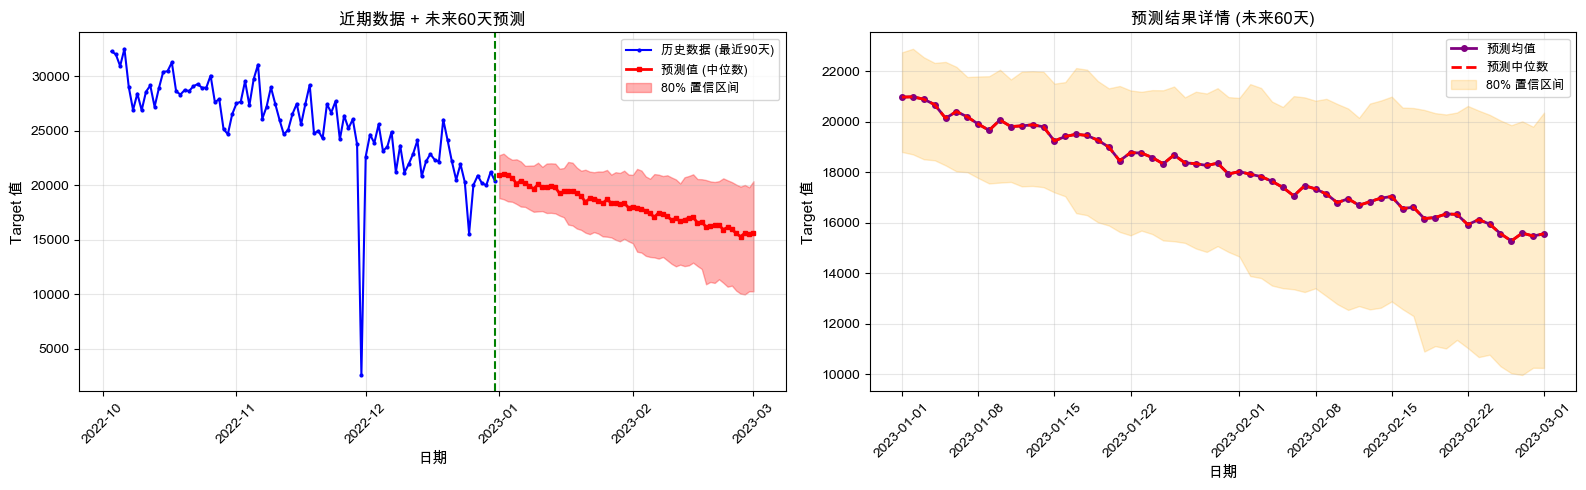


预测统计信息:
预测时间范围: 2023-01-01 到 2023-03-01
预测均值范围: 15280 ~ 20989
预测中位数范围: 15280 ~ 20989


In [22]:
# 详细展示：放大预测区域
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 左图：只显示最近90天历史数据 + 预测
recent_days = 90
recent_ts_df = ts_df.tail(recent_days)

axes[0].plot(recent_ts_df['timestamp'], recent_ts_df['target'], 
             label='历史数据 (最近90天)', color='blue', linewidth=1.5, marker='o', markersize=2)
axes[0].plot(pred_df['timestamp'], pred_df['0.5'], 
             label='预测值 (中位数)', color='red', linewidth=2, marker='s', markersize=3)
axes[0].fill_between(pred_df['timestamp'], 
                     pred_df['0.1'], pred_df['0.9'],
                     alpha=0.3, color='red', label='80% 置信区间')
axes[0].axvline(x=last_historical_date, color='green', linestyle='--', linewidth=1.5)
axes[0].set_xlabel('日期', fontsize=11)
axes[0].set_ylabel('Target 值', fontsize=11)
axes[0].set_title('近期数据 + 未来60天预测', fontsize=12)
axes[0].legend(loc='upper right', fontsize=9)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# 右图：预测结果的详细视图
axes[1].plot(pred_df['timestamp'], pred_df['predictions'], 
             label='预测均值', color='purple', linewidth=2, marker='o', markersize=4)
axes[1].plot(pred_df['timestamp'], pred_df['0.5'], 
             label='预测中位数', color='red', linewidth=2, linestyle='--')
axes[1].fill_between(pred_df['timestamp'], 
                     pred_df['0.1'], pred_df['0.9'],
                     alpha=0.2, color='orange', label='80% 置信区间')
axes[1].set_xlabel('日期', fontsize=11)
axes[1].set_ylabel('Target 值', fontsize=11)
axes[1].set_title('预测结果详情 (未来60天)', fontsize=12)
axes[1].legend(loc='upper right', fontsize=9)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 打印预测统计信息
print("\n预测统计信息:")
print(f"预测时间范围: {pred_df['timestamp'].min().strftime('%Y-%m-%d')} 到 {pred_df['timestamp'].max().strftime('%Y-%m-%d')}")
print(f"预测均值范围: {pred_df['predictions'].min():.0f} ~ {pred_df['predictions'].max():.0f}")
print(f"预测中位数范围: {pred_df['0.5'].min():.0f} ~ {pred_df['0.5'].max():.0f}")